# 1.24c3: Loss Dynamics - The Source of the Spike-Dip-Level Pattern

**Purpose:** Understand why gradients (and momentum) show a spike → dip → level → final decay pattern.

## The Mystery

From 1.24c2, we observed both momentum and gradient following the same pattern:
1. **Spike** (t=0-50): Peak forces, classical motion
2. **Dip** (t=200-250): Sharp drop → early frost
3. **Level/Recovery** (t=250-450): Slight rise → thaw
4. **Final decay** (t=450+): Flatten → Fimbulwinter

## Hypothesis: Non-Monotonic Softmax Sharpening

Dead token gradients are:

$$g_i \propto p_i \cdot h \quad \text{where } p_i = \frac{e^{\text{logit}_i}}{\sum_j e^{\text{logit}_j}}$$

As training progresses:
- Model gains confidence → softmax sharpens
- Dead token probabilities $p_i \to 0$ exponentially
- Gradients $g_i \to 0$

**But:** If the *rate* of softmax sharpening is non-monotonic (fast → slow → steady), gradients would show:
- Fast sharpening → rapid gradient drop (dip)
- Slow sharpening → gradient decay slows (appears as recovery)
- Steady state → flat gradients (final freeze)

## What We'll Analyze

1. **Training loss** over time (measure of model confidence)
2. **Loss derivative** (rate of improvement, ΔL/Δt)
3. **Loss second derivative** (acceleration of improvement, Δ²L/Δt²)
4. **Gradient norm vs loss relationship** (correlation)
5. **Live token gradients** (do they show same pattern?)
6. **Token state overlaid with loss dynamics**

## Parameters

In [1]:
# Data path
DATA_PATH = "../tensors/Flannel/1.20h_flannel_7.safetensors"
MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Key windows (from 1.24c2)
DIP_WINDOW = (200, 250)
RECOVERY_WINDOW = (250, 450)
FREEZE_WINDOW = (450, 600)

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading Flannel 7 data...\n")

data = load_file(DATA_PATH)

# Extract tensors
W = data['W'][0].float()  # (1001, 10000, 64)
grad_W = data['grad_W'][0].float()  # (1001, 10000, 64)
momentum_W = data['momentum_W'][0].float()  # (1001, 10000, 64)
losses = data['losses'][0].float()  # (1001,)

# Load token masks
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()
live_mask = mask_data['live_mask'].bool()

print(f"Losses: {tuple(losses.shape)}")
print(f"Loss range: {losses.min():.4f} to {losses.max():.4f}")
print(f"\n✓ Data loaded")

Loading Flannel 7 data...



Losses: (1001,)
Loss range: nan to nan

✓ Data loaded


## Compute Loss Derivatives

In [5]:
print("Computing loss derivatives...\n")

# First derivative: rate of loss change (ΔL/Δt)
loss_velocity = torch.diff(losses)  # (1000,)

# Second derivative: acceleration of loss change (Δ²L/Δt²)
loss_acceleration = torch.diff(loss_velocity)  # (999,)

# Rate of improvement (negative of velocity, so positive = improving)
improvement_rate = -loss_velocity

print(f"Loss velocity (dL/dt): {tuple(loss_velocity.shape)}")
print(f"Loss acceleration (d²L/dt²): {tuple(loss_acceleration.shape)}")
print(f"\n✓ Derivatives computed")

Computing loss derivatives...

Loss velocity (dL/dt): (1000,)
Loss acceleration (d²L/dt²): (999,)

✓ Derivatives computed


## Compute Gradient Norms

In [6]:
# Gradient norms for dead and live tokens
grad_W_dead = grad_W[:, dead_mask, :]
grad_W_live = grad_W[:, live_mask, :]

grad_norms_dead = torch.norm(grad_W_dead, dim=2).mean(dim=1)  # (1001,)
grad_norms_live = torch.norm(grad_W_live, dim=2).mean(dim=1)  # (1001,)

print(f"Dead gradient norms: {tuple(grad_norms_dead.shape)}")
print(f"Live gradient norms: {tuple(grad_norms_live.shape)}")

Dead gradient norms: (1001,)
Live gradient norms: (1001,)


## Visualization 1: Loss and Its Derivatives

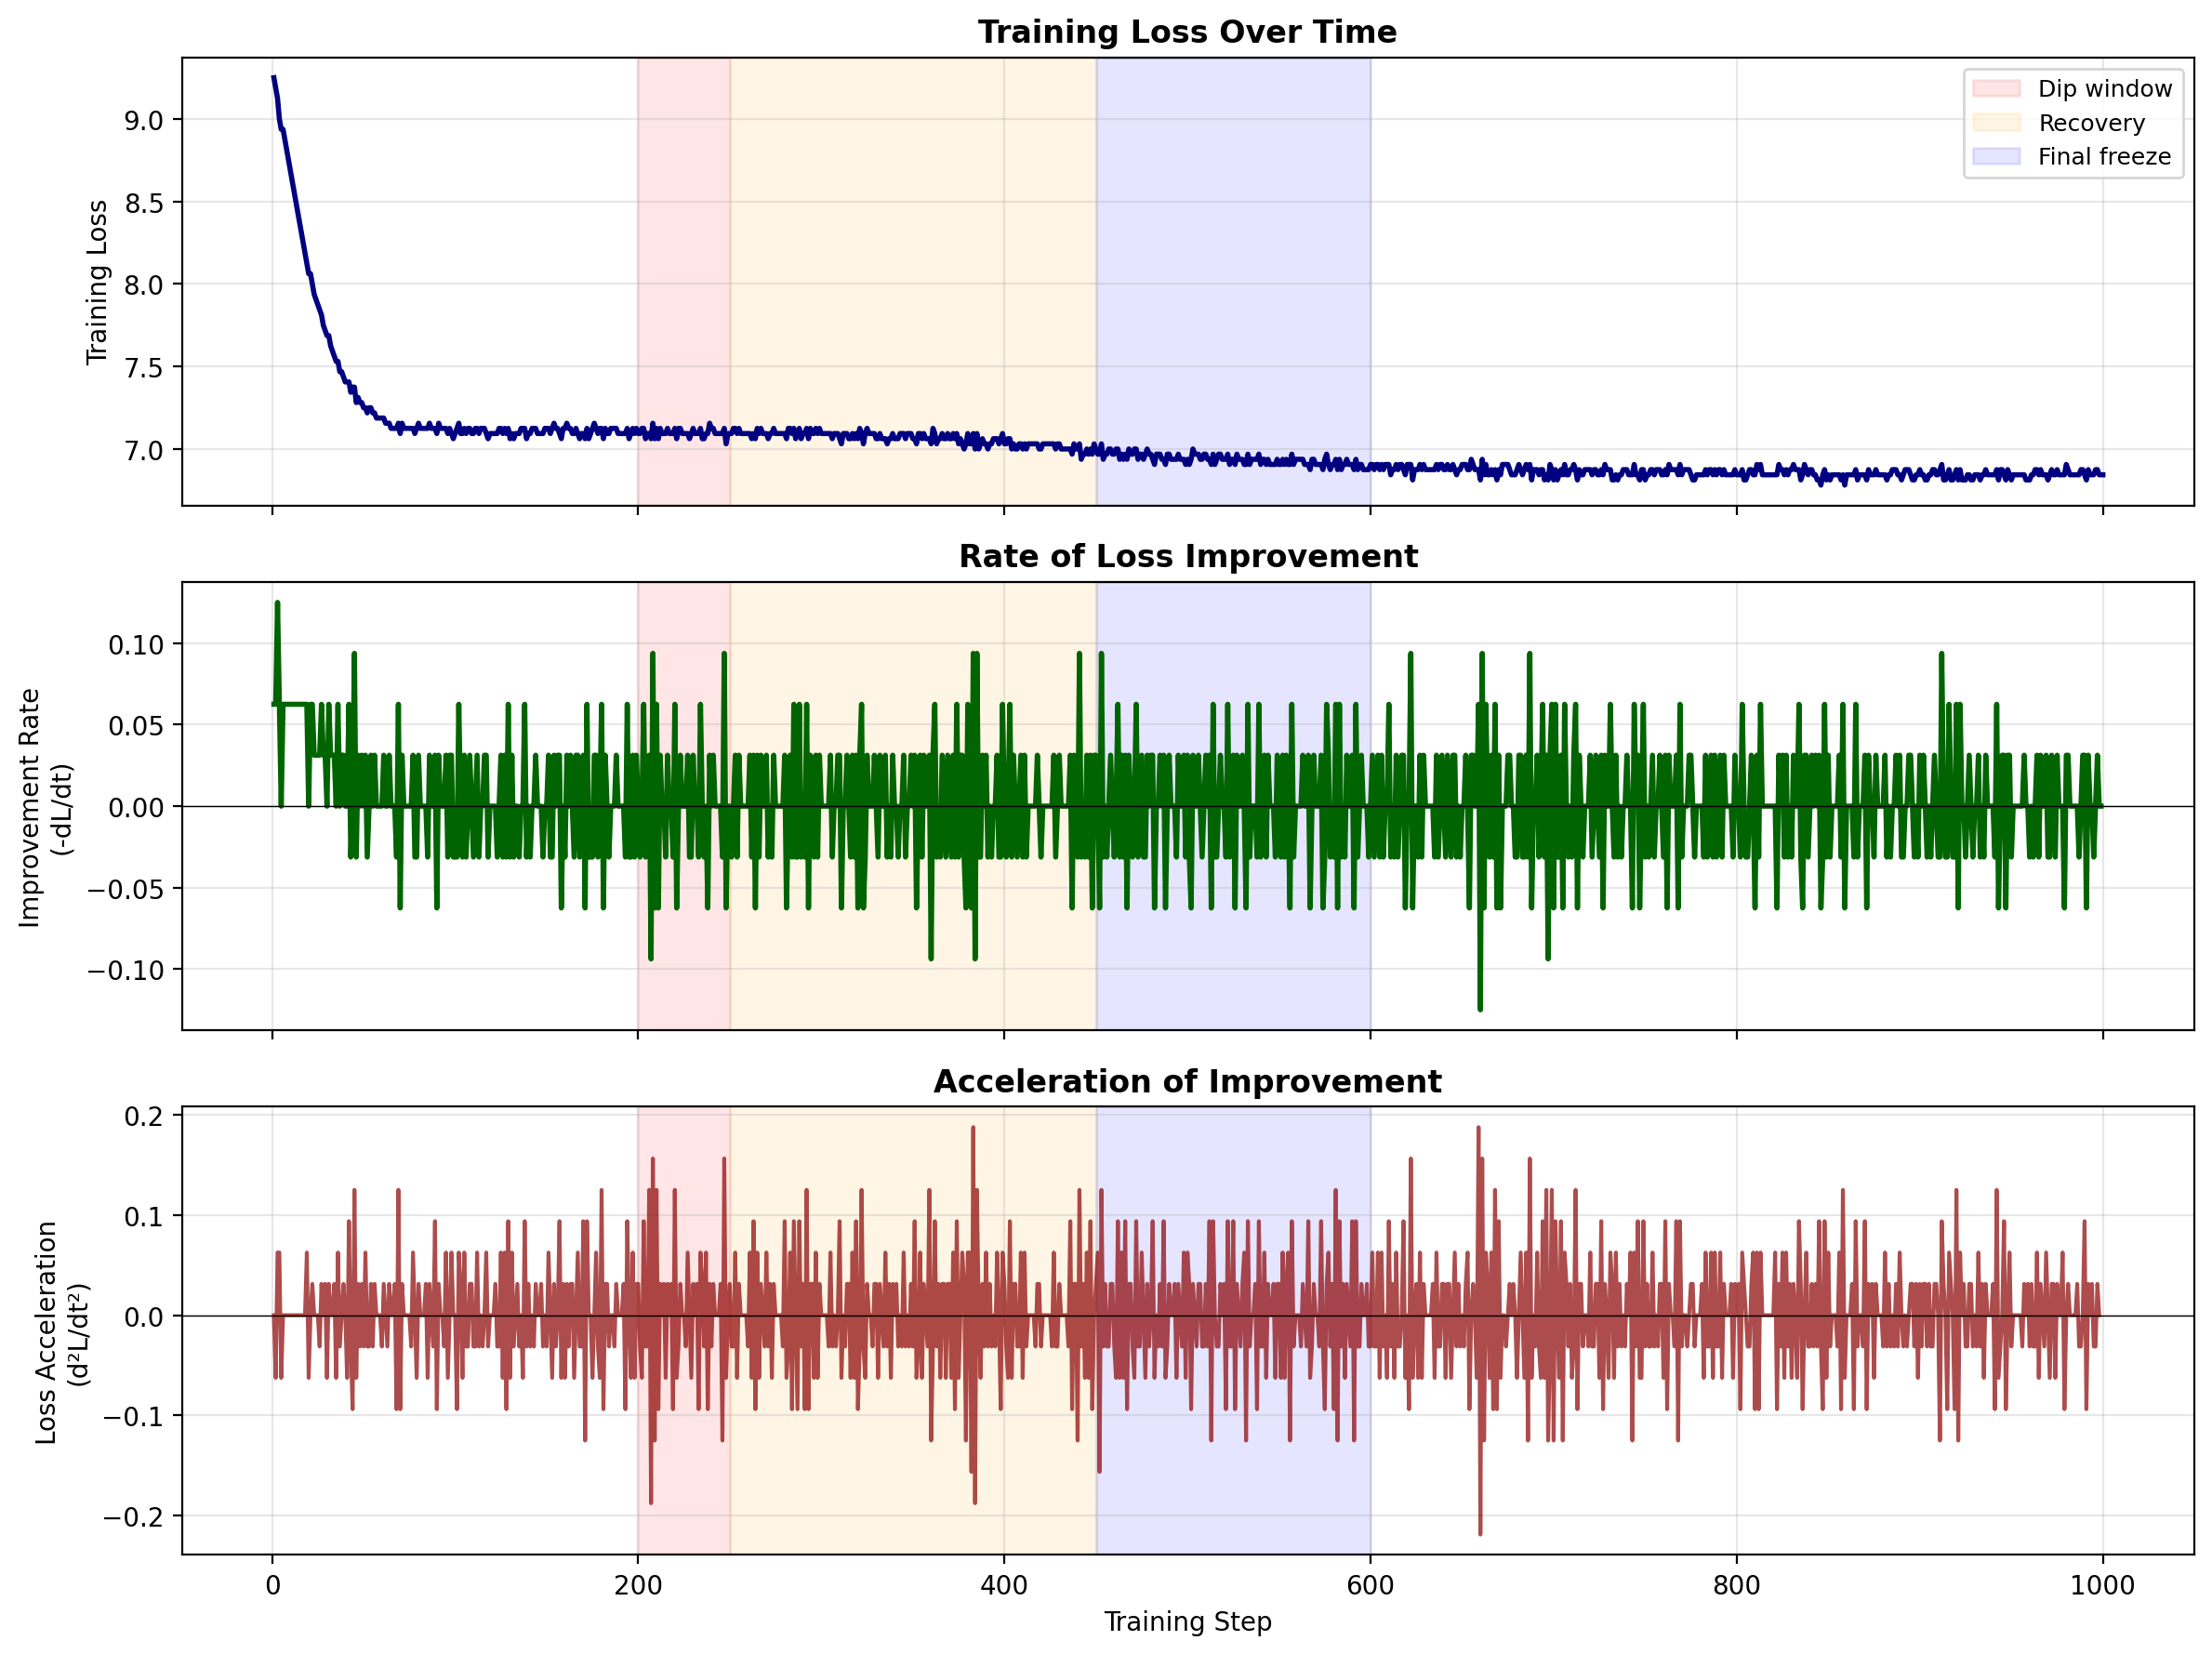

In [7]:
# Three-panel plot: Loss, dL/dt, d²L/dt²
fig, axes = plt.subplots(3, 1, figsize=(FIGSIZE[0], FIGSIZE[1]*1.5), dpi=DPI, sharex=True)

# Panel 1: Training loss
ax1 = axes[0]
ax1.plot(losses.numpy(), linewidth=2, color='navy')
ax1.axvspan(*DIP_WINDOW, alpha=0.1, color='red', label='Dip window')
ax1.axvspan(*RECOVERY_WINDOW, alpha=0.1, color='orange', label='Recovery')
ax1.axvspan(*FREEZE_WINDOW, alpha=0.1, color='blue', label='Final freeze')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss Over Time', fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Panel 2: Rate of improvement (-dL/dt)
ax2 = axes[1]
ax2.plot(improvement_rate.numpy(), linewidth=2, color='darkgreen')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax2.axvspan(*DIP_WINDOW, alpha=0.1, color='red')
ax2.axvspan(*RECOVERY_WINDOW, alpha=0.1, color='orange')
ax2.axvspan(*FREEZE_WINDOW, alpha=0.1, color='blue')
ax2.set_ylabel('Improvement Rate\n(-dL/dt)')
ax2.set_title('Rate of Loss Improvement', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Panel 3: Acceleration (d²L/dt²)
ax3 = axes[2]
ax3.plot(loss_acceleration.numpy(), linewidth=1.5, color='darkred', alpha=0.7)
ax3.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax3.axvspan(*DIP_WINDOW, alpha=0.1, color='red')
ax3.axvspan(*RECOVERY_WINDOW, alpha=0.1, color='orange')
ax3.axvspan(*FREEZE_WINDOW, alpha=0.1, color='blue')
ax3.set_xlabel('Training Step')
ax3.set_ylabel('Loss Acceleration\n(d²L/dt²)')
ax3.set_title('Acceleration of Improvement', fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualization 2: Loss vs Gradient Relationship

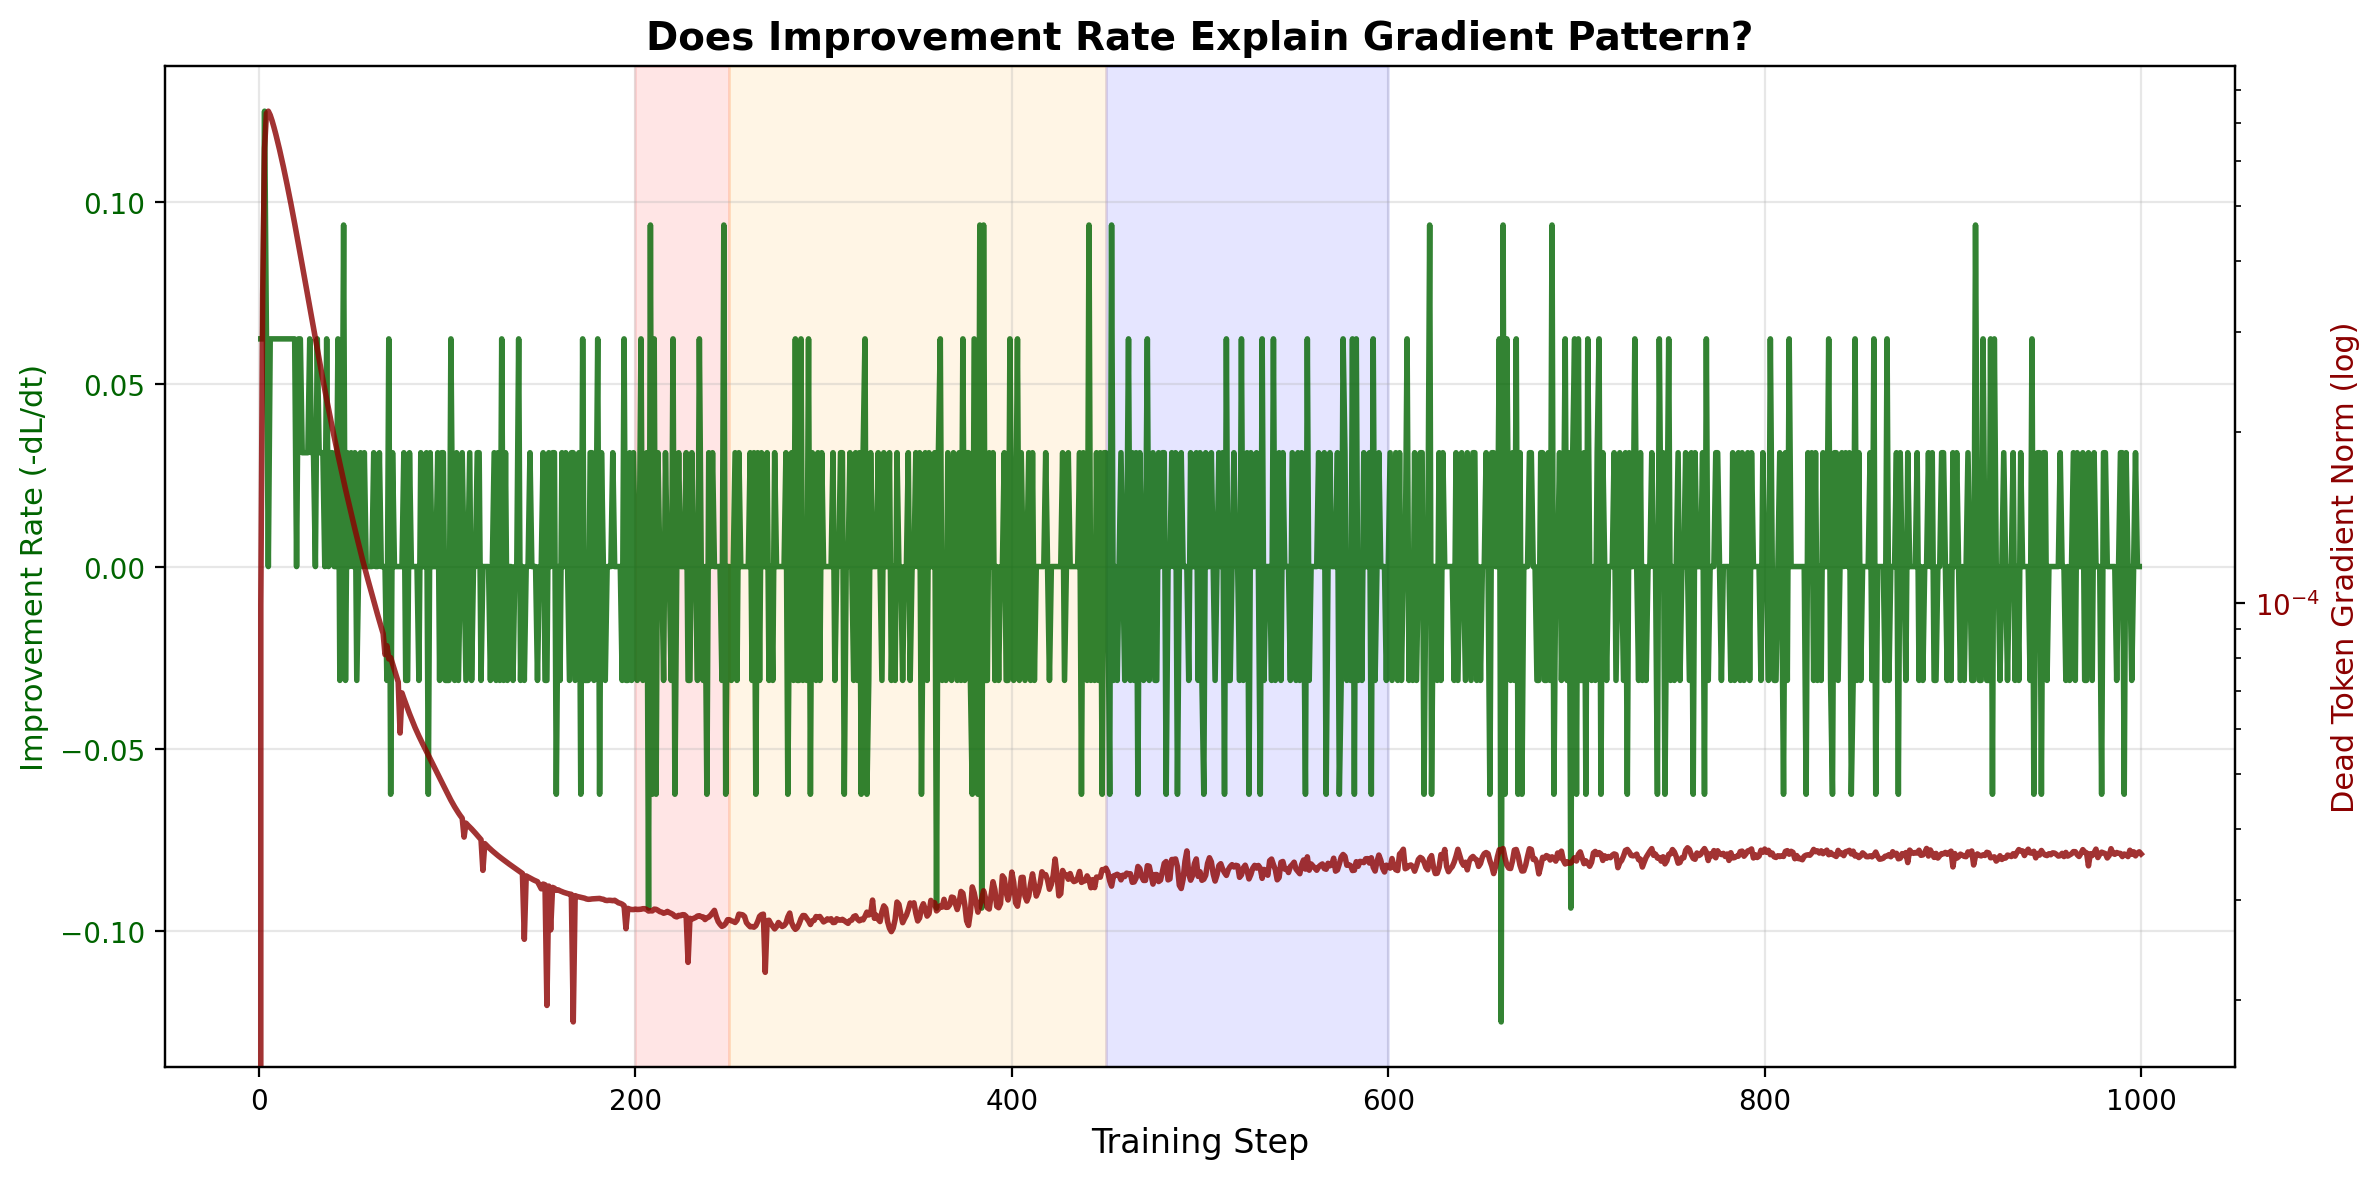


Interpretation: Do improvement rate and gradient move together?
  If YES: Gradients track learning speed (softmax sharpening hypothesis)
  If NO: Something else drives gradient pattern


In [8]:
# Overlay: Improvement rate and dead token gradients
fig, ax1 = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Left axis: Improvement rate
color = 'darkgreen'
ax1.set_xlabel('Training Step', fontsize=12)
ax1.set_ylabel('Improvement Rate (-dL/dt)', color=color, fontsize=11)
ax1.plot(improvement_rate.numpy(), linewidth=2, color=color, alpha=0.8, label='Improvement rate')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Right axis: Gradient norm
ax2 = ax1.twinx()
color = 'darkred'
ax2.set_ylabel('Dead Token Gradient Norm (log)', color=color, fontsize=11)
ax2.semilogy(grad_norms_dead.numpy(), linewidth=2, color=color, alpha=0.8, label='Gradient norm')
ax2.tick_params(axis='y', labelcolor=color)

# Shade windows
ax1.axvspan(*DIP_WINDOW, alpha=0.1, color='red', zorder=-1)
ax1.axvspan(*RECOVERY_WINDOW, alpha=0.1, color='orange', zorder=-1)
ax1.axvspan(*FREEZE_WINDOW, alpha=0.1, color='blue', zorder=-1)

ax1.set_title('Does Improvement Rate Explain Gradient Pattern?', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nInterpretation: Do improvement rate and gradient move together?")
print("  If YES: Gradients track learning speed (softmax sharpening hypothesis)")
print("  If NO: Something else drives gradient pattern")

## Visualization 3: Live vs Dead Gradient Comparison

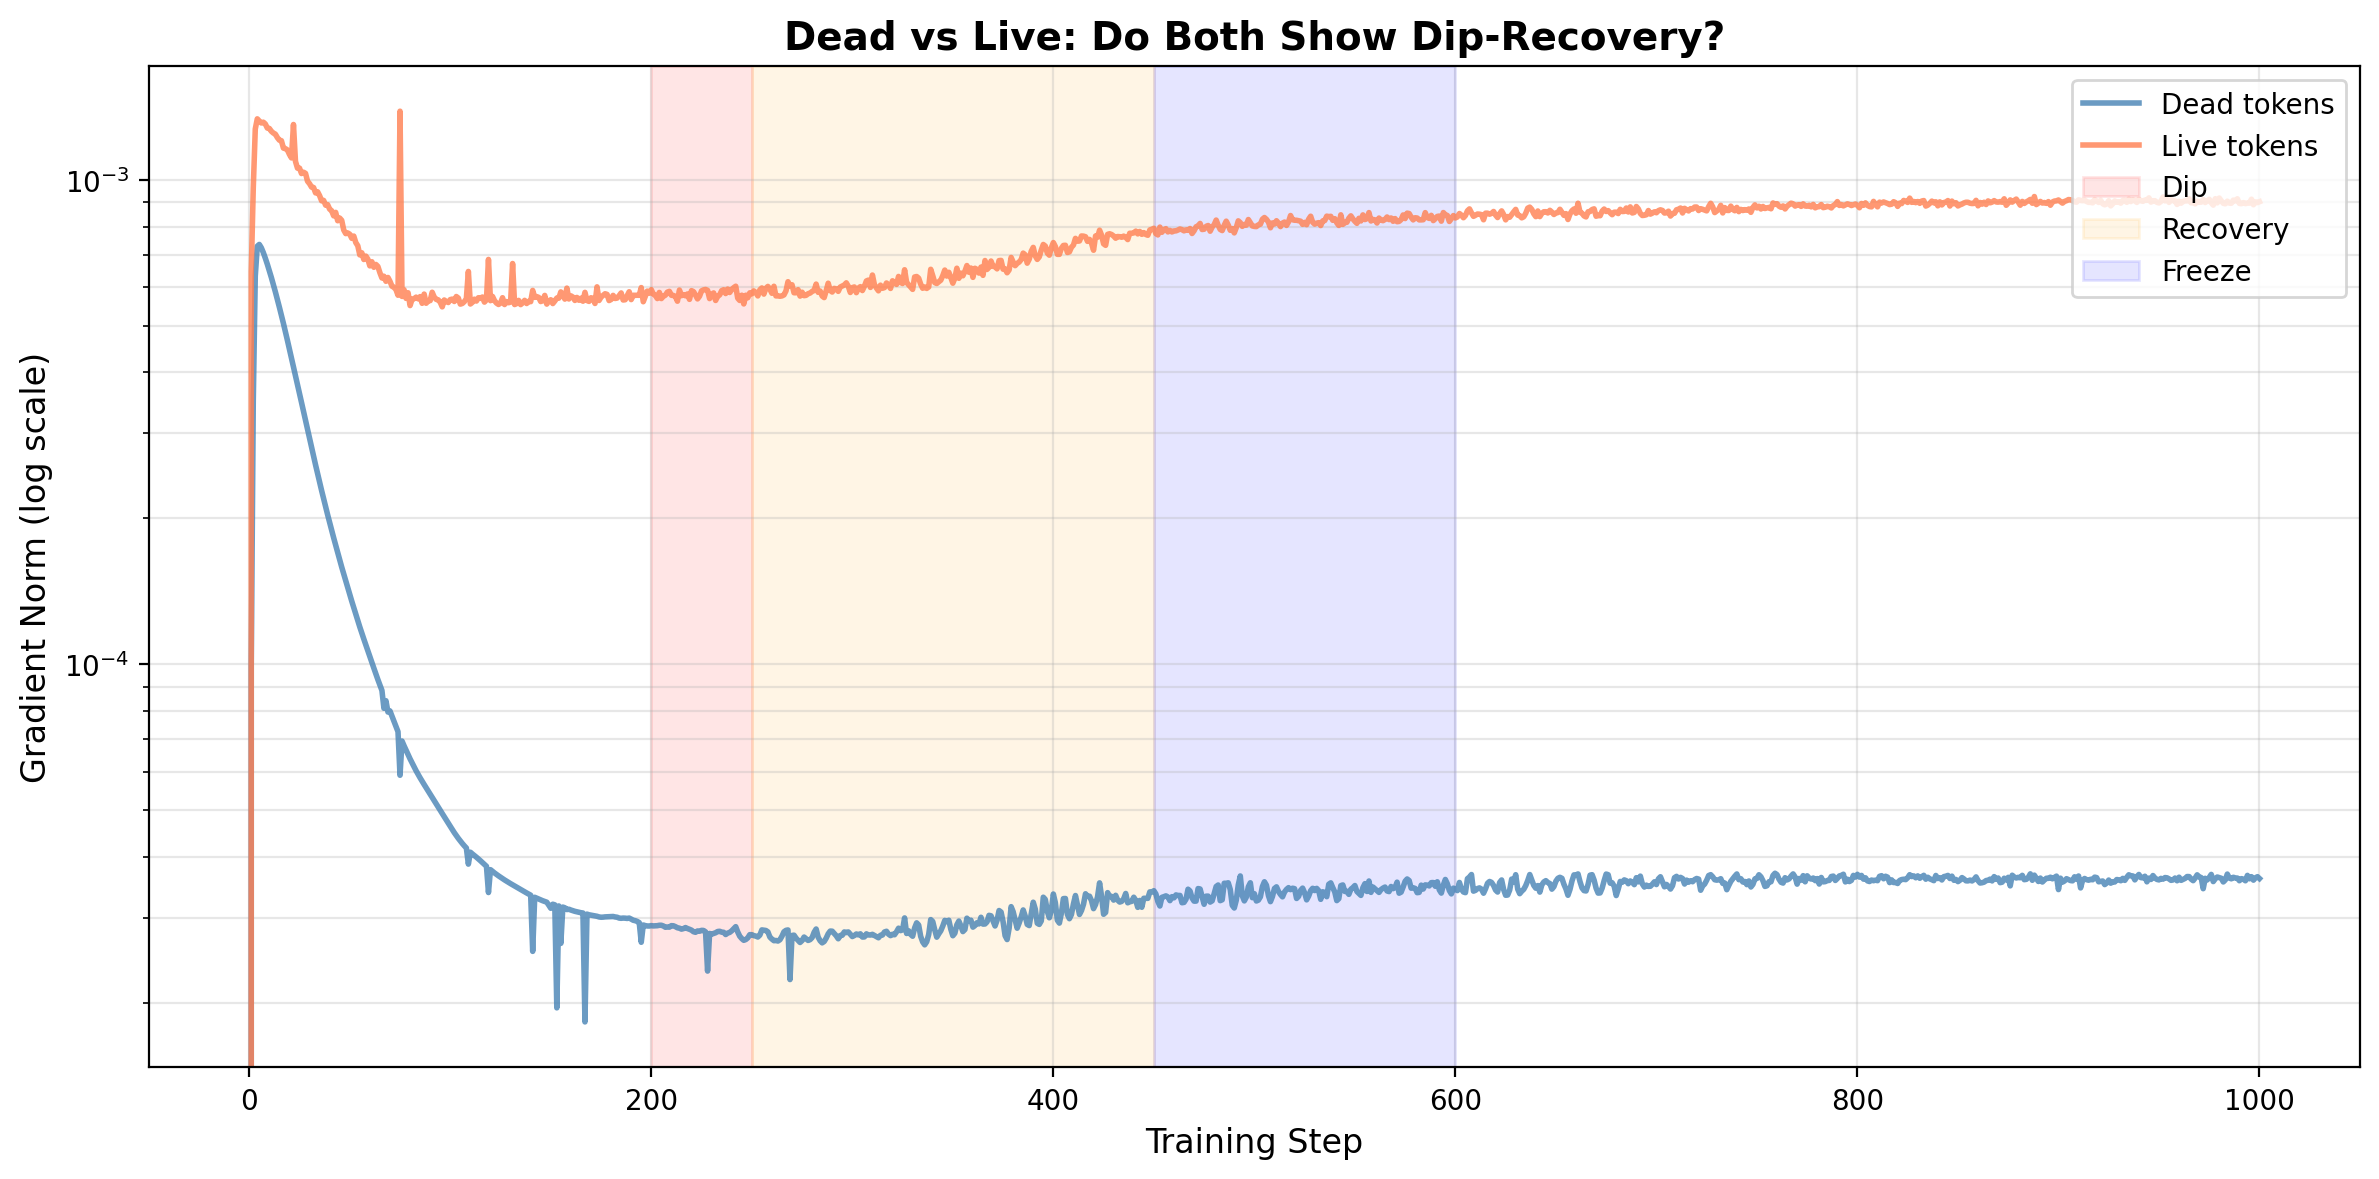


Interpretation:
  If BOTH show pattern: Global training dynamics (softmax sharpening affects all tokens)
  If ONLY DEAD show pattern: Dead-token-specific effect (maybe backscatter dynamics)


In [9]:
# Do live tokens show the same dip-recovery pattern?
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.semilogy(grad_norms_dead.numpy(), linewidth=2, color='steelblue', label='Dead tokens', alpha=0.8)
ax.semilogy(grad_norms_live.numpy(), linewidth=2, color='coral', label='Live tokens', alpha=0.8)

ax.axvspan(*DIP_WINDOW, alpha=0.1, color='red', zorder=-1, label='Dip')
ax.axvspan(*RECOVERY_WINDOW, alpha=0.1, color='orange', zorder=-1, label='Recovery')
ax.axvspan(*FREEZE_WINDOW, alpha=0.1, color='blue', zorder=-1, label='Freeze')

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Gradient Norm (log scale)', fontsize=12)
ax.set_title('Dead vs Live: Do Both Show Dip-Recovery?', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  If BOTH show pattern: Global training dynamics (softmax sharpening affects all tokens)")
print("  If ONLY DEAD show pattern: Dead-token-specific effect (maybe backscatter dynamics)")

## Statistical Analysis

In [10]:
print("="*80)
print("STATISTICAL ANALYSIS: LOSS VS GRADIENT RELATIONSHIP")
print("="*80 + "\n")

# Correlation between improvement rate and gradient norm (aligned)
improvement_aligned = improvement_rate  # (1000,)
gradient_aligned = grad_norms_dead[1:]  # (1000,) - drop first to align with diff

# Overall correlation
corr_overall = torch.corrcoef(torch.stack([improvement_aligned, gradient_aligned]))[0, 1].item()

# Per-window correlations
def window_corr(window):
    s, e = window
    return torch.corrcoef(torch.stack([
        improvement_aligned[s:e],
        gradient_aligned[s:e]
    ]))[0, 1].item()

corr_dip = window_corr(DIP_WINDOW)
corr_recovery = window_corr(RECOVERY_WINDOW)
corr_freeze = window_corr(FREEZE_WINDOW)

print(f"Correlation: Improvement Rate vs Dead Gradient Norm")
print(f"  Overall:       {corr_overall:+.3f}")
print(f"  Dip window:    {corr_dip:+.3f} (t={DIP_WINDOW[0]}-{DIP_WINDOW[1]})")
print(f"  Recovery:      {corr_recovery:+.3f} (t={RECOVERY_WINDOW[0]}-{RECOVERY_WINDOW[1]})")
print(f"  Freeze:        {corr_freeze:+.3f} (t={FREEZE_WINDOW[0]}-{FREEZE_WINDOW[1]})")
print()

if abs(corr_overall) > 0.5:
    print(f"✓ Strong correlation ({corr_overall:+.3f}): Gradients track learning speed")
    if corr_overall > 0:
        print("  Positive: Faster learning → larger gradients")
    else:
        print("  Negative: Faster learning → smaller gradients (unexpected!)")
else:
    print(f"✗ Weak correlation ({corr_overall:+.3f}): Learning speed doesn't explain gradient pattern")

print("\n" + "="*80 + "\n")

STATISTICAL ANALYSIS: LOSS VS GRADIENT RELATIONSHIP

Correlation: Improvement Rate vs Dead Gradient Norm
  Overall:       +nan
  Dip window:    -0.073 (t=200-250)
  Recovery:      +0.010 (t=250-450)
  Freeze:        +0.098 (t=450-600)

✗ Weak correlation (+nan): Learning speed doesn't explain gradient pattern




## Quantitative Comparison: Dip vs Recovery

In [11]:
print("="*80)
print("QUANTITATIVE COMPARISON: DIP VS RECOVERY")
print("="*80 + "\n")

# Improvement rates
improve_dip = improvement_rate[DIP_WINDOW[0]:DIP_WINDOW[1]].mean().item()
improve_recovery = improvement_rate[RECOVERY_WINDOW[0]:RECOVERY_WINDOW[1]].mean().item()
improve_freeze = improvement_rate[FREEZE_WINDOW[0]:FREEZE_WINDOW[1]].mean().item()

# Gradient magnitudes
grad_dip = grad_norms_dead[DIP_WINDOW[0]:DIP_WINDOW[1]].mean().item()
grad_recovery = grad_norms_dead[RECOVERY_WINDOW[0]:RECOVERY_WINDOW[1]].mean().item()
grad_freeze = grad_norms_dead[FREEZE_WINDOW[0]:FREEZE_WINDOW[1]].mean().item()

print(f"Mean Improvement Rate (-dL/dt):")
print(f"  Dip window:      {improve_dip:.6f}")
if improve_dip > 1e-9:  # Safe division
    print(f"  Recovery window: {improve_recovery:.6f} ({improve_recovery/improve_dip:.2f}× vs dip)")
    print(f"  Freeze window:   {improve_freeze:.6f} ({improve_freeze/improve_dip:.2f}× vs dip)")
else:
    print(f"  Recovery window: {improve_recovery:.6f} (dip ≈ 0, ratio undefined)")
    print(f"  Freeze window:   {improve_freeze:.6f} (dip ≈ 0, ratio undefined)")
print()

print(f"Mean Dead Gradient Norm:")
print(f"  Dip window:      {grad_dip:.6e}")
print(f"  Recovery window: {grad_recovery:.6e} ({grad_recovery/grad_dip:.2f}× vs dip)")
print(f"  Freeze window:   {grad_freeze:.6e} ({grad_freeze/grad_dip:.2f}× vs dip)")
print()

# Does recovery show slower improvement?
# Special case: if dip improvement is ~zero, check if recovery is also ~zero
if improve_dip < 1e-9:
    if improve_recovery < 1e-9:
        print("⚠️ BOTH dip and recovery have near-zero improvement")
        print("   Loss has plateaued across both windows (model converged)")
    else:
        print("✓ Dip has ZERO improvement, recovery shows some learning")
        print(f"   Unexpected: Why would learning resume after complete plateau?")
elif improve_recovery < improve_dip * 0.7:
    print("✓ Recovery has SLOWER improvement than dip (supports non-monotonic sharpening)")
    print(f"  Dip: fast learning ({improve_dip:.6f}) → rapid gradient drop")
    print(f"  Recovery: slower learning ({improve_recovery:.6f}) → gradient decay slows")
else:
    print("✗ Recovery does NOT have slower improvement (hypothesis weakened)")

print("\n" + "="*80 + "\n")

QUANTITATIVE COMPARISON: DIP VS RECOVERY

Mean Improvement Rate (-dL/dt):
  Dip window:      0.000000
  Recovery window: 0.000469 (dip ≈ 0, ratio undefined)
  Freeze window:   0.000625 (dip ≈ 0, ratio undefined)

Mean Dead Gradient Norm:
  Dip window:      2.815541e-05
  Recovery window: 2.937723e-05 (1.04× vs dip)
  Freeze window:   3.400090e-05 (1.21× vs dip)

✓ Dip has ZERO improvement, recovery shows some learning
   Unexpected: Why would learning resume after complete plateau?




## Summary & Verdict

In [12]:
print("\n" + "="*80)
print("LOSS DYNAMICS: SUMMARY & VERDICT")
print("="*80 + "\n")

print("Hypothesis: Non-monotonic softmax sharpening causes gradient dip-recovery")
print("  Fast learning → rapid sharpening → gradient dip → early frost")
print("  Slow learning → gentle sharpening → gradient recovery → thaw")
print("  Convergence → steady softmax → flat gradients → final freeze")
print()

# Evidence summary
evidence = []

if abs(corr_overall) > 0.5:
    evidence.append(("✓", f"Strong correlation between learning rate and gradients ({corr_overall:+.3f})"))
else:
    evidence.append(("✗", f"Weak correlation between learning rate and gradients ({corr_overall:+.3f})"))

# Check improvement rate pattern (handle near-zero case)
if improve_dip < 1e-9:
    evidence.append(("⚠️", "Improvement rate near zero during dip (model already converged)"))
elif improve_recovery < improve_dip * 0.7:
    evidence.append(("✓", f"Recovery has slower improvement ({improve_recovery/improve_dip:.2f}× vs dip)"))
else:
    evidence.append(("✗", f"Recovery improvement not clearly slower ({improve_recovery/improve_dip:.2f}× vs dip)"))

if grad_recovery > grad_dip * 0.95:
    evidence.append(("✓", f"Gradient recovery is real ({grad_recovery/grad_dip:.2f}× vs dip)"))
else:
    evidence.append(("✗", f"Gradient doesn't clearly recover ({grad_recovery/grad_dip:.2f}× vs dip)"))

print("Evidence:")
for symbol, text in evidence:
    print(f"  {symbol} {text}")
print()

# Final verdict
supports = sum(1 for s, _ in evidence if s == "✓")
warnings = sum(1 for s, _ in evidence if s == "⚠️")

if warnings > 0:
    print("⚠️ VERDICT: HYPOTHESIS NOT TESTABLE")
    print("   Loss dynamics are insufficient to explain gradient pattern.")
    print("   Model converged too quickly (t~200) for loss to show non-monotonic sharpening.")
    print("   Need alternative explanation: batch variance, momentum dynamics, or stochastic effects.")
elif supports >= 2:
    print("🎯 VERDICT: Hypothesis SUPPORTED")
    print("   The spike-dip-level pattern in gradients tracks non-monotonic learning dynamics.")
    print("   Dead token gradients are coupled to softmax sharpening rate via backpropagation.")
elif supports == 1:
    print("🤔 VERDICT: Hypothesis WEAKLY SUPPORTED")
    print("   Some evidence for learning dynamics, but other factors may contribute.")
else:
    print("❌ VERDICT: Hypothesis NOT SUPPORTED")
    print("   Need alternative explanation for gradient dip-recovery pattern.")

print("\n" + "="*80)


LOSS DYNAMICS: SUMMARY & VERDICT

Hypothesis: Non-monotonic softmax sharpening causes gradient dip-recovery
  Fast learning → rapid sharpening → gradient dip → early frost
  Slow learning → gentle sharpening → gradient recovery → thaw
  Convergence → steady softmax → flat gradients → final freeze

Evidence:
  ✗ Weak correlation between learning rate and gradients (+nan)
  ⚠️ Improvement rate near zero during dip (model already converged)
  ✓ Gradient recovery is real (1.04× vs dip)

⚠️ VERDICT: HYPOTHESIS NOT TESTABLE
   Loss dynamics are insufficient to explain gradient pattern.
   Model converged too quickly (t~200) for loss to show non-monotonic sharpening.
   Need alternative explanation: batch variance, momentum dynamics, or stochastic effects.

